In [474]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from torchvision import transforms
from transformers import OFATokenizer, OFAModel
from transformers.models.ofa.generate import sequence_generator
from transformers.models.ofa.modeling_ofa import OFAEncoder

In [475]:
import pandas as pd
from PIL import Image
import io
import base64

# Load the data
data = pd.read_csv('dataset/vision_language_examples.tsv', delimiter='\t', header=None)

# Select the first row's image data (assuming it's in the second column)
image_data = data.iloc[7, 1]

# Decode the base64 string
image_bytes = base64.b64decode(image_data)

# Convert to a bytes buffer
image_buffer = io.BytesIO(image_bytes)

# Open the image
image = Image.open(image_buffer)

# Display the image if you are in a Jupyter notebook environment
image.show()

In [476]:
# also take the caption
caption = data.iloc[7, 2]
caption

'ewa makai teacher walking around classroom while giving a lecture to her students.'

In [477]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480
patch_resize_transform = transforms.Compose([
        lambda image: image.convert("RGB"),
        transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
        transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std)
    ])

In [478]:
ckpt_dir = 'OFA-base'
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)

OFA-base
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [479]:
# txt = "Is the person's hair brown and long?"
# txt = "Why do you think he is wearing a suit?"
# txt = " what currency is this?"
# txt = "what number is the small hand on?"
# txt = "what sort of vehicle uses this item?"
# txt = "why is the woman pointing a gun at the man?"
txt = 'what animal is there in the picture?'
inputs = tokenizer([txt], return_tensors="pt").input_ids
image = Image.open('examples/vqa/gqa_1.png')
patch_img = patch_resize_transform(image).unsqueeze(0)

In [480]:
model = OFAEncoder.from_pretrained(ckpt_dir)
generator = sequence_generator.SequenceGenerator(
                    tokenizer=tokenizer,
                    beam_size=3,
                    max_len_b=10, 
                    min_len=0,
                    no_repeat_ngram_size=3,
                    temperature=0.5,
                )

Some weights of the model checkpoint at OFA-base were not used when initializing OFAEncoder: ['encoder.embed_images.layer1.1.bn3.num_batches_tracked', 'encoder.embed_images.layer3.2.bn2.running_var', 'encoder.embed_images.layer2.1.bn2.bias', 'encoder.layers.4.fc2.bias', 'encoder.embed_images.layer3.19.conv3.weight', 'decoder.self_pos_q_linear.weight', 'encoder.embed_images.layer3.3.bn2.num_batches_tracked', 'decoder.embed_positions.weight', 'encoder.embed_images.layer3.6.bn2.num_batches_tracked', 'decoder.layers.5.fc1.bias', 'encoder.embed_images.layer3.9.bn1.bias', 'encoder.embed_images.layer3.10.bn1.num_batches_tracked', 'decoder.image_rel_pos_table_list.4.weight', 'encoder.embed_images.layer3.18.bn3.num_batches_tracked', 'decoder.layers.3.cross_attn.q_proj.weight', 'encoder.embed_images.layer2.1.bn3.bias', 'encoder.embed_images.layer3.6.conv1.weight', 'encoder.layers.4.fc1.bias', 'encoder.embed_images.layer3.16.bn3.num_batches_tracked', 'decoder.layers.1.cross_attn_layer_norm.bias',

In [481]:
data = {}
data["net_input"] = {"input_ids": inputs, 'patch_images': patch_img, 'patch_masks':torch.tensor([True])}
# gen_output = generator.generate([model], data)
# gen = [gen_output[i][0]["tokens"] for i in range(len(gen_output))]

In [482]:
# decoded_output = tokenizer.batch_decode(gen, skip_special_tokens=True)
# print(decoded_output)

In [483]:
output = model.forward(input_ids=inputs, patch_images=patch_img, patch_masks=torch.tensor([True]))

Type of input_ids: <class 'torch.Tensor'>
Shape of input_ids: torch.Size([1, 10])


In [484]:
position_embeddings = output.position_embedding
position_embeddings.shape

torch.Size([1, 910, 768])

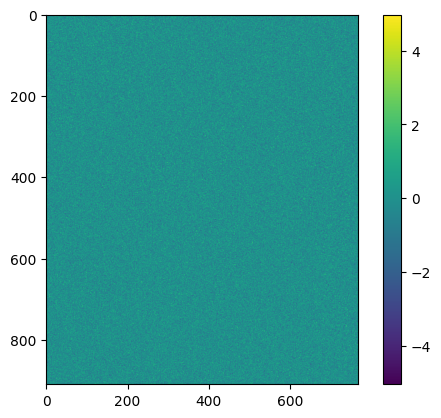

In [485]:
import matplotlib.pyplot as plt

# Assuming position_embeddings is a 2D array
plt.imshow(position_embeddings.detach().numpy()[0], cmap='viridis')
plt.colorbar()
plt.show()

In [486]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Convert torch tensor to numpy array if not already in numpy format
if isinstance(position_embeddings, torch.Tensor):
    embeddings = position_embeddings.detach().cpu().numpy()[0]  # Assuming batch size of 1
else:
    embeddings = position_embeddings  # If already a numpy array

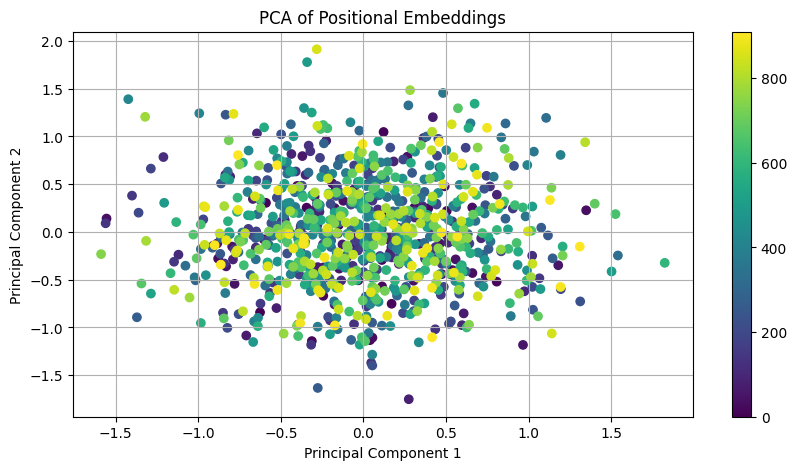

In [502]:
# Reducing dimensions to 2 for PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot PCA
plt.figure(figsize=(10, 5))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=np.arange(embeddings_pca.shape[0]), cmap='viridis')
plt.colorbar()
plt.title('PCA of Positional Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

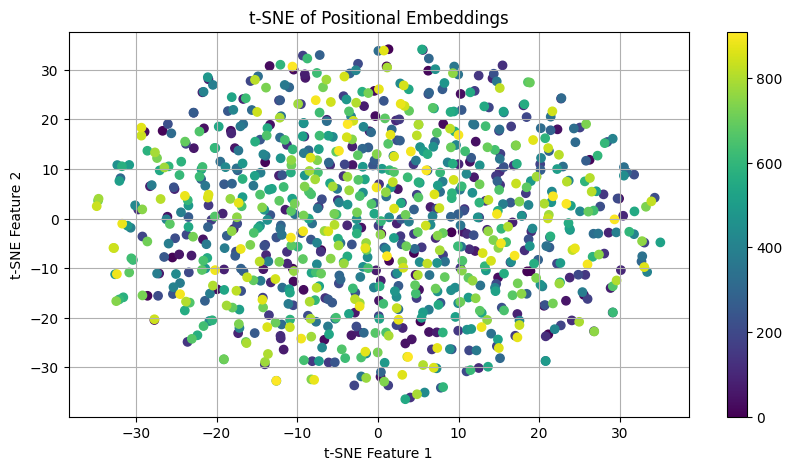

In [488]:
# Reducing dimensions to 2 for t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot t-SNE
plt.figure(figsize=(10, 5))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=np.arange(embeddings_tsne.shape[0]), cmap='viridis')
plt.colorbar()
plt.title('t-SNE of Positional Embeddings')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.grid(True)
plt.show()

## Dummy input for separating modalities

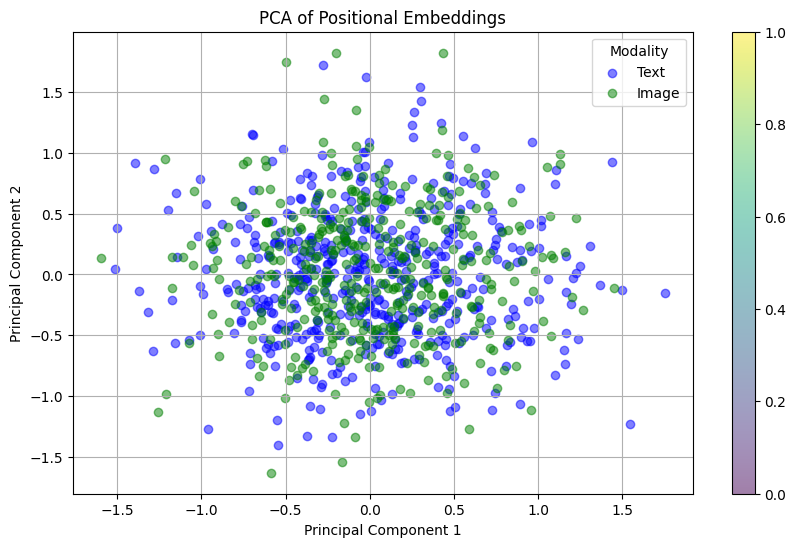

In [489]:
# Example tensor of embeddings
embeddings = torch.rand(911, 768)  # Random data for demonstration

# Simulate a split of text and image embeddings
num_text_tokens = 500  # Example split
labels = np.array(['Text'] * num_text_tokens + ['Image'] * (911 - num_text_tokens))

# Perform PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10, 6))
for label, color in zip(['Text', 'Image'], ['blue', 'green']):
    mask = labels == label
    plt.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], label=label, color=color, alpha=0.5)

plt.title('PCA of Positional Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Modality')
plt.colorbar()
plt.grid(True)
plt.show()

In [490]:
position_embeddings.view(-1, position_embeddings.size(-1)).shape

torch.Size([910, 768])

In [491]:
position_embeddings.shape

torch.Size([1, 910, 768])

In [492]:
pos_patch = position_embeddings.view(14, -1)

In [499]:
pos_patch.shape

torch.Size([14, 49920])

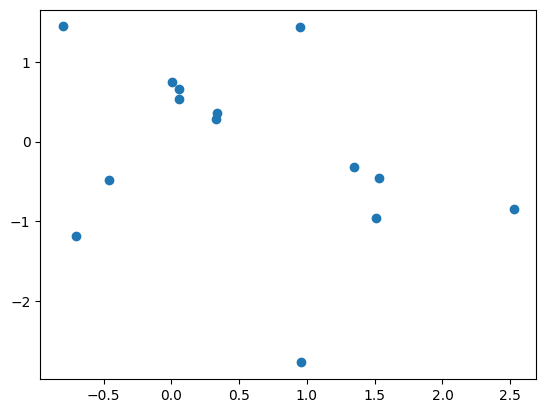

In [497]:
plt.scatter(pos_patch[:, 0].detach().numpy(), pos_patch[:, 1].detach().numpy())

<Axes: >

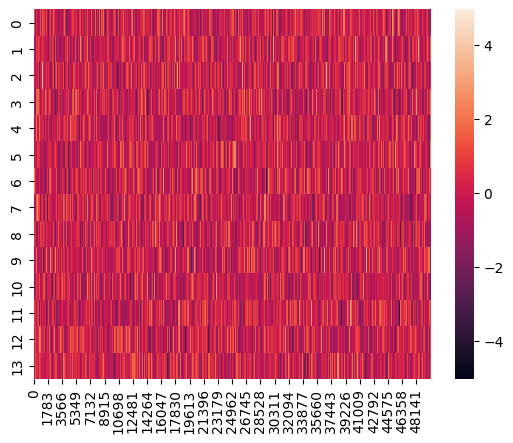

In [494]:
sns.heatmap(pos_patch.detach().numpy())